In [2]:
# imports a library 'pandas', names it as 'pd'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import re
import urllib.request

from IPython.display import Image

# enables inline plots, without it plots don't show up in the notebook
%matplotlib inline

Challenge 1

Open up a new IPython notebook
Download a few MTA turnstile data files
Read them into a pandas dataframe (pd.read_csv()), format the columns nicely, and display the first few rows.

In [2]:
# list all datafiles from MTA website
response = urllib.request.urlopen("http://web.mta.info/developers/turnstile.html")
mta_html = response.read()
datafiles_list = re.findall(r'turnstile_\d\d\d\d\d\d.txt', str(mta_html))

In [3]:
# download and append dfs together for all files from 2016
i = 1
year_to_analyze = ['16'] # analyzing 2016 data
for datafile in datafiles_list:
    year = re.findall(r'turnstile_(\d\d)\d\d\d\d.txt', str(datafile))
    if year == year_to_analyze:
        if i == 1:
            df = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/' + datafile)
        else:
            df = df.append(pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/' + datafile))
            break
        i += 1
print("Downloaded " + str(i) + " files from MTA website")

# index gets repeated from each week - to be reset
df = df.reset_index()

Downloaded 2 files from MTA website


Challenge 2

Let's turn this into a time series.

In [4]:
# convert and concatenate date and time into new single column as timestamp
df['DateTime'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'])

In [23]:
df.rename(columns = {'EXITS                                                               ' : 'EXITS'},inplace=True)
df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DateTime"], inplace=True, ascending=False)
df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DateTime"], inplace=True)

In [24]:
# create turnstile specific key
df['Turnstile_ID'] = df['C/A'] + ',' + df['UNIT'] + ',' + df['SCP'] + ',' + df['STATION']
df.head()

,index,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DateTime,Turnstile_ID,Substation_ID
192347,192347,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,12/30/2016,20:00:00,REGULAR,5554,283,2016-12-30 20:00:00,"TRAM2,R469,00-05-01,RIT-ROOSEVELT","TRAM2,R469,RIT-ROOSEVELT"
192346,192346,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,12/30/2016,16:00:00,REGULAR,5554,283,2016-12-30 16:00:00,"TRAM2,R469,00-05-01,RIT-ROOSEVELT","TRAM2,R469,RIT-ROOSEVELT"
192345,192345,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,12/30/2016,12:00:00,REGULAR,5554,283,2016-12-30 12:00:00,"TRAM2,R469,00-05-01,RIT-ROOSEVELT","TRAM2,R469,RIT-ROOSEVELT"
192344,192344,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,12/30/2016,08:00:00,REGULAR,5554,283,2016-12-30 08:00:00,"TRAM2,R469,00-05-01,RIT-ROOSEVELT","TRAM2,R469,RIT-ROOSEVELT"
192343,192343,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,12/30/2016,04:00:00,REGULAR,5554,283,2016-12-30 04:00:00,"TRAM2,R469,00-05-01,RIT-ROOSEVELT","TRAM2,R469,RIT-ROOSEVELT"


Challenge 3

These counts are for every n hours (What is n?). Also, there's something odd about these "counts", what is it? Do they actually represent total entries for a time period, or something else? We want total daily entries, create a new dataframe with one row per turnstile/day and a column that gives total daily entries.

In [25]:
# aggregate on a turnstile level per day
daily_df_turnstiles = \
(df
    .groupby(['Turnstile_ID',pd.Grouper(freq='D',key="DateTime")])['ENTRIES']
    .agg(['min','max'])
    .diff(axis=1)
    .dropna(axis=1, how='all')
    .reset_index()
    .rename(columns = {'DateTime' : 'Date', 'max' : 'Entries_per_day'})
)
daily_df_turnstiles.head()

,Turnstile_ID,Date,Entries_per_day
0,"A002,R051,02-00-00,59 ST",2016-12-17,952.0
1,"A002,R051,02-00-00,59 ST",2016-12-18,724.0
2,"A002,R051,02-00-00,59 ST",2016-12-19,1846.0
3,"A002,R051,02-00-00,59 ST",2016-12-20,1900.0
4,"A002,R051,02-00-00,59 ST",2016-12-21,2264.0


Challenge 4

We will plot the daily time series for a turnstile.

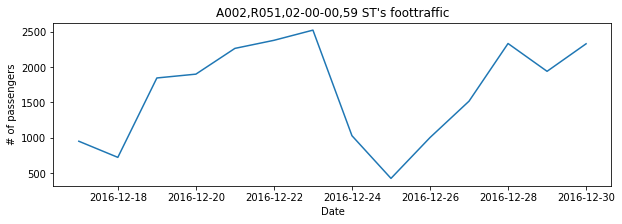

In [26]:
# Take a sample for a single turnstile and plot time series
plt.figure(figsize=(10,3))
sample_df = daily_df_turnstiles[daily_df_turnstiles.Turnstile_ID == 'A002,R051,02-00-00,59 ST']

plt.xlabel("Date")
plt.ylabel("# of passengers")
plt.title("A002,R051,02-00-00,59 ST's foottraffic")
plt.plot(sample_df.Date,sample_df.Entries_per_day)

Challenge 5

So far we've been operating on a single turnstile level, let's combine turnstiles in the same ControlArea/Unit/Station combo. There are some ControlArea/Unit/Station groups that have a single turnstile, but most have multiple turnstilea-- same value for the C/A, UNIT and STATION columns, different values for the SCP column.
We want to combine the numbers together -- for each ControlArea/UNIT/STATION combo, for each day, add the counts from each turnstile belonging to that combo.

In [27]:
# create substation specific key
df['Substation_ID'] = df['C/A'] + ',' + df['UNIT'] + ',' + df['STATION']

In [28]:
# aggregate on a substation level per day
daily_df_substation = \
(df
    .groupby(['Substation_ID', 'SCP', pd.Grouper(freq='D',key="DateTime")])['ENTRIES']
    .agg(['min','max'])
    .diff(axis=1)
    .dropna(axis=1, how='all')
    .reset_index()
    .rename(columns = {'DateTime' : 'Date', 'max' : 'Entries_per_day'})
)
daily_df_substation.head()

,Substation_ID,SCP,Date,Entries_per_day
0,"A002,R051,59 ST",02-00-00,2016-12-17,952.0
1,"A002,R051,59 ST",02-00-00,2016-12-18,724.0
2,"A002,R051,59 ST",02-00-00,2016-12-19,1846.0
3,"A002,R051,59 ST",02-00-00,2016-12-20,1900.0
4,"A002,R051,59 ST",02-00-00,2016-12-21,2264.0


In [29]:
daily_df_substation = \
(daily_df_substation
    .groupby(['Substation_ID', 'Date'])
    .agg({'SCP':'nunique'})
)
daily_df_substation.head()

SCP  Entries_per_day
Substation_ID   Date                            
A002,R051,59 ST 2016-12-17   12          10078.0
                2016-12-18   12           8468.0
                2016-12-19   12          17864.0
                2016-12-20   12          18482.0
                2016-12-21   12          18532.0

Challenge 6

Similarly, combine everything in each station, and come up with a time series of [(date1, count1),(date2,count2),...] type of time series for each STATION, by adding up all the turnstiles in a station.

In [30]:
# aggregate on a statiom level per day
daily_df_station = \
(df
    .groupby(['STATION','C/A', 'UNIT', 'SCP', pd.Grouper(freq='D',key="DateTime")])['ENTRIES']
    .agg(['min','max'])
    .diff(axis=1)
    .dropna(axis=1, how='all')
    .reset_index()
    .rename(columns = {'DateTime' : 'Date', 'max' : 'Entries_per_day'})
)

daily_df_station = \
(daily_df_station
    .groupby(['STATION','Date'])
    .agg({'Entries_per_day':'sum'})
    .reset_index()
)
daily_df_station.head()

,STATION,Date,Entries_per_day
0,1 AV,2016-12-17,15763.0
1,1 AV,2016-12-18,12637.0
2,1 AV,2016-12-19,21449.0
3,1 AV,2016-12-20,21347.0
4,1 AV,2016-12-21,20676.0


Challenge 7

Plot the time series for a station.

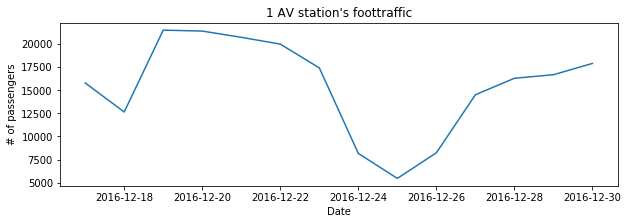

In [31]:
# Take a sample for a station and plot time series
sample_df = daily_df_station[daily_df_station.STATION == '1 AV']

plt.figure(figsize=(10,3))
plt.xlabel("Date")
plt.ylabel("# of passengers")
plt.title("1 AV station's foottraffic")
plt.plot(sample_df.Date,sample_df.Entries_per_day)

Challenge 8

Make one list of counts for one week for one station. Monday's count, Tuesday's count, etc. so it's a list of 7 counts. Make the same list for another week, and another week, and another week. plt.plot(week_count_list) for every week_count_list you created this way. You should get a rainbow plot of weekly commute numbers on top of each other.

/Users/krisztian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/krisztian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/krisztian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if sys.path[0] == '':


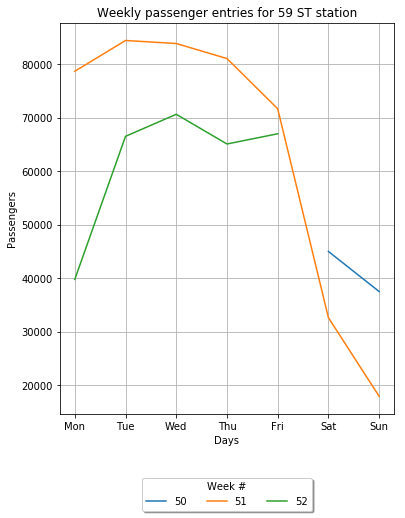

In [33]:
station_to_filter = "59 ST"
#print(daily_df_station.STATION.unique())

# format Date into datetime format
sample_df = daily_df_station[daily_df_station.STATION == station_to_filter]
sample_df['Weekday'] = pd.to_datetime(sample_df['Date']).dt.weekday # Monday=0, Sunday=6
sample_df['Week'] = pd.to_datetime(sample_df['Date']).dt.week #week ordinal of the year

# aggregate for a sample station per week, per days
sample_df = \
(sample_df
    .groupby(['Week', 'Weekday'])['Entries_per_day']
    .agg({'Entries_per_day':'sum'})
    .reset_index()
)

weekday_names = "Mon Tue Wed Thu Fri Sat Sun".split(' ')

fig, ax = plt.subplots()
for name, group in sample_df.groupby(['Week']):
    start_day= group.Weekday.min()
    
    #convert date to week age
    Xs = group.Weekday
    Ys = group.Entries_per_day
    ax.plot(Xs, Ys, label=name)

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5, title="Week #")

# Setup grid, titles and ticklabels
plt.grid()
plt.xlabel("Days")
plt.ylabel("Passengers")
plt.title("Weekly passenger entries for "+station_to_filter+" station")
ax.set_xticklabels(weekday_names)
ax.set_xticks(range(0, len(weekday_names)))

plt.show()

Challenge 9

Over multiple weeks, sum total ridership for each station and sort them, so you can find out the stations with the highest traffic during the time you investigate

In [15]:
# aggregate on a statiom level per day
daily_df_station = \
(df
    .groupby(['STATION','C/A', 'UNIT', 'SCP', pd.Grouper(freq='D',key="DateTime")])['ENTRIES']
    .agg(['min','max'])
    .diff(axis=1)
    .dropna(axis=1, how='all')
    .reset_index()
    .rename(columns = {'DateTime' : 'Date', 'max' : 'Entries_per_day'})
)

daily_df_station = \
(daily_df_station
    .groupby('STATION')
    .agg({'Entries_per_day':'sum'})
    .reset_index()
)
daily_df_station = daily_df_station.sort_values('Entries_per_day', ascending = False)
daily_df_station.head()

,STATION,Entries_per_day
77,5 AVE,986132080.0
9,125 ST,135029454.0
258,KINGS HWY,114256138.0
304,OCEAN PKWY,111576359.0
186,CLINTON-WASH AV,84112396.0


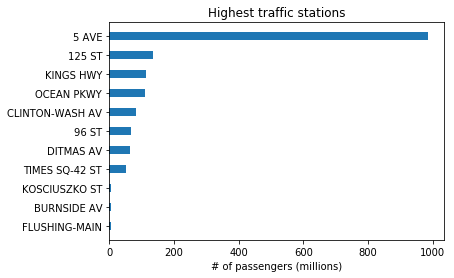

In [16]:
number_to_plot = 10

ypos = np.arange(len(daily_df_station.STATION[0:number_to_plot+1]))

plt.yticks(ypos, daily_df_station.STATION[0:number_to_plot+1])
plt.xlabel("# of passengers (millions)")
plt.title("Highest traffic stations")
plt.barh(ypos,daily_df_station.Entries_per_day[0:number_to_plot+1]/1000000, height=0.4)
plt.gca().invert_yaxis()

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

Challenge 10

Make a single list of these total ridership values and plot it with

plt.hist(total_ridership_counts)

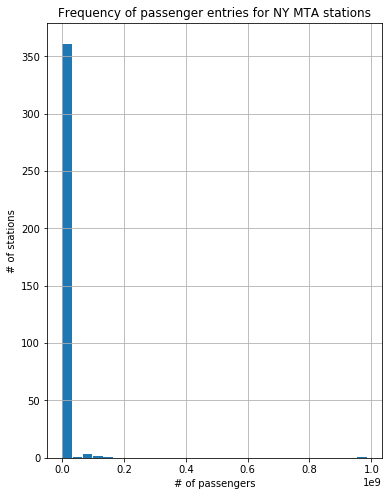

In [17]:
data = daily_df_station['Entries_per_day']
plt.hist(data, rwidth=0.95, bins=30)
plt.grid()
plt.xlabel("# of passengers")
plt.ylabel("# of stations")
plt.title("Frequency of passenger entries for NY MTA stations")
plt.show()

---

GROUP WORK - PROJECT BENSON

In [18]:
# aggregate on a station and unit level per day
daily_df_SCP = \
(df
    .groupby(['STATION','C/A', 'UNIT', 'SCP','LINENAME', pd.Grouper(freq='D',key="DateTime")])
    .agg({'ENTRIES':['min','max'], 'EXITS':['min','max']})
    .diff(axis=1)
    .dropna(axis=1, how='all')
    .rename(columns = {'DateTime' : 'Date', 'ENTRIES' : 'Entries total', 'EXITS' : 'Exits total'})
    .reset_index()
)
del daily_df_SCP['Exits total', 'min']

daily_df_SCP.columns = daily_df_SCP.columns.droplevel(1)

In [19]:
daily_df_SCP.head()

,STATION,C/A,UNIT,SCP,LINENAME,DateTime,Entries total,Exits total
0,1 AV,H007,R248,00-00-00,L,2016-12-17,2702.0,3788.0
1,1 AV,H007,R248,00-00-00,L,2016-12-18,2029.0,3172.0
2,1 AV,H007,R248,00-00-00,L,2016-12-19,3916.0,3615.0
3,1 AV,H007,R248,00-00-00,L,2016-12-20,4305.0,3904.0
4,1 AV,H007,R248,00-00-00,L,2016-12-21,3963.0,4058.0


In [20]:
daily_df_UNIT = \
(daily_df_SCP
    .groupby(['STATION','UNIT','LINENAME'])
    .agg({'Entries total':'mean','Exits total':'mean'})
    .reset_index()
)

daily_df_UNIT['Entries total'] = daily_df_UNIT['Entries total']/1000
daily_df_UNIT['Exits total'] = daily_df_UNIT['Exits total']/1000
daily_df_UNIT['ENTRY_per_EXIT_RATIO'] = daily_df_UNIT['Entries total']/daily_df_UNIT['Exits total']

In [21]:
daily_df_UNIT.head(30)

,STATION,UNIT,LINENAME,Entries total,Exits total,ENTRY_per_EXIT_RATIO
0,1 AV,R248,L,1.545564,1.735386,0.890617
1,103 ST,R180,6,1.835012,1.377738,1.331902
2,103 ST,R191,1,1.583226,0.684798,2.311962
3,103 ST,R314,BC,1.097357,0.675000,1.625714
4,103 ST-CORONA,R208,7,1.853706,1.233968,1.502232
5,104 ST,R007,JZ,0.525500,0.263679,1.992957
6,104 ST,R354,A,0.250743,0.087443,2.867505
7,110 ST,R181,6,1.579476,1.141524,1.383656
8,111 ST,R008,J,0.470482,0.283482,1.659654
9,111 ST,R310,7,1.926129,1.148786,1.676665
